# Load and split data

In [100]:
import random
import numpy as np
import tensorflow as tf

# Set the random seeds
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [101]:
# Charger les données MNIST
mnist = tf.keras.datasets.mnist

# Diviser les données en ensembles d'entraînement et de test
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Pour normaliser les données, divisez-les par 255.0 (la valeur maximale possible)
x_train, x_test = x_train / 255.0, x_test / 255.0

# Ajouter une dimension pour les canaux
x_train = np.expand_dims(x_train, axis=-1) # (60000, 28, 28) -> (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1) # (10000, 28, 28) -> (10000, 28, 28, 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

In [103]:
# # Mélanger les données

# shuffle_indices = np.arange(len(x_train))
# np.random.shuffle(shuffle_indices)

# x_train = x_train[shuffle_indices]
# y_train = y_train[shuffle_indices]



# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [104]:
# Créer les datasets labelisés et non labelisés

def create_original_datasets():
    # Sélectionner 10 images de chaque chiffre
    indices = []
    for digit in range(10):
        digit_indices = np.where(y_train == digit)[0][:10]
        indices.extend(digit_indices)

    # Créer le dataset labelisés (100 images)
    x_labeled_dataset = x_train[indices]
    y_labeled_dataset = y_train[indices]

    # Créer le second dataset (le reste des images)
    mask = np.ones(len(x_train), dtype=bool)
    mask[indices] = False
    x_unlabeled_dataset = x_train[mask]
    y_unlabeled_dataset = y_train[mask]

    return x_labeled_dataset, y_labeled_dataset, x_unlabeled_dataset, y_unlabeled_dataset

# Afficher les dimensions des datasets
# x_labeled_dataset.shape, y_labeled_dataset.shape, x_unlabeled_dataset.shape, y_unlabeled_dataset.shape

# Data augmentation

In [106]:
from keras.preprocessing.image import ImageDataGenerator

# Créez un générateur de data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # Rotation aléatoire de l'image jusqu'à 10 degrés
    shear_range=0.2,  # Inclinaison aléatoire de l'image
    zoom_range=0.2,  # Zoom aléatoire de l'image
    horizontal_flip=False,  # Retournement horizontal aléatoire
    fill_mode='nearest' # Remplissage des pixels manquants
)

def concatenate(x1, y1, x2, y2, shuffle=True):
    new_x = np.concatenate([x1, x2], axis=0)
    new_y = np.concatenate([y1, y2], axis=0)

    if shuffle:
        # Mélanger les données
        shuffle_indices = np.arange(len(new_x))
        np.random.shuffle(shuffle_indices)
        new_x = new_x[shuffle_indices]
        new_y = new_y[shuffle_indices]
    
    return new_x, new_y


def create_augmented_data(x, y, augmentation_factor=10):
    new_x = []
    new_y = []
    for i in range(x.shape[0]):
        img = x[i]
        img = np.expand_dims(img, axis=0)
        for _ in range(augmentation_factor):
            for batch in datagen.flow(img, batch_size=1, shuffle=False):
                # Ajouter les images augmentées à la liste
                new_x.append(batch[0])
                new_y.append(y[i])
                break    
    
    return concatenate(x, y, new_x, new_y)

In [ ]:
import matplotlib.pyplot as plt

def show_digit(digit, label=None):
  # Afficher la première image d'entraînement
  plt.imshow(digit)
  if label is not None:
    plt.title(f"{label}")
  plt.show()

In [107]:
# plt.figure(figsize=(10, 10))

# for i in range(100):
#     plt.subplot(10, 10, i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(x_labeled_dataset[i], cmap=plt.cm.binary)
#     plt.xlabel(y_labeled_dataset[i])

# plt.show()

# Create model

In [108]:
# lenet-5 with keras
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

def create_new_model(model_name="lenet-5"):
    if model_name == "lenet-5":
        model = Sequential([
            Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(28, 28, 1)),
            AveragePooling2D(pool_size=(2, 2)),
            Conv2D(16, kernel_size=(5, 5), activation='tanh'),
            AveragePooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(120, activation='tanh'),
            Dense(84, activation='tanh'),
            Dense(10, activation='softmax')
            ])

        model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
    
        return model
    
    elif model_name == "alexnet":
        model = Sequential([
            Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=(28, 28, 1)),
            AveragePooling2D(pool_size=(3, 3), strides=2),
            Conv2D(256, kernel_size=(5, 5), strides=1, activation='relu'),
            AveragePooling2D(pool_size=(3, 3), strides=2),
            Conv2D(384, kernel_size=(3, 3), strides=1, activation='relu'),
            Conv2D(384, kernel_size=(3, 3), strides=1, activation='relu'),
            Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu'),
            AveragePooling2D(pool_size=(3, 3), strides=2),
            Flatten(),
            Dense(4096, activation='relu'),
            Dense(4096, activation='relu'),
            Dense(10, activation='softmax')
            ])

        model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
    
        return model
    
    else:
        print("Model not found!")
        return None

# model.summary()

# Train model (Semi Supervised Learning)

In [110]:
import time
from math import log

start = time.time()

# Créer un nouveau modèle
model = create_new_model()

# Créer les datasets
x_labeled_dataset, y_labeled_dataset, x_unlabeled_dataset, _ = create_original_datasets() 
x_labeled_dataset, y_labeled_dataset = create_augmented_data(x_labeled_dataset, y_labeled_dataset, augmentation_factor=35)

# Créer un tableau de pseudo labels
pseudo_labels = [np.nan] * len(x_unlabeled_dataset)
pseudo_labels = np.array(pseudo_labels)

# Définir les seuils
min_threshold = 0.9
max_threshold = 0.9999999
threshold_decrement = 0.0001
threshold = max_threshold

# Définir les listes pour stocker les résultats
losses = []
accuracies = []
thresholds = []
unlabeled_images = []

it = 0

while len(x_unlabeled_dataset) > 0:
    t = time.time()
    it += 1
    print("--------------------------------------------------")
    print("iteration:", it)
    print("number of labeled images:", len(x_labeled_dataset))
    print("number of unlabeled images:", len(x_unlabeled_dataset))
    unlabeled_images.append(len(x_unlabeled_dataset))

    
    # Train the model (supervised learning) 
    print("fitting the model")
    model.fit(datagen.flow(x_labeled_dataset, y_labeled_dataset, batch_size=64), epochs=20, verbose=0, steps_per_epoch=len(x_labeled_dataset) // 64)

    # Evaluate the model (loss and accuracy)
    print("evaluating the model on", len(x_test), "test images")
    loss, accuracy = model.evaluate(x_test, y_test)
    losses.append(loss)
    accuracies.append(accuracy)
    
    # Set the threshold
    if threshold > min_threshold:
        threshold -= threshold_decrement * log(it, 10) ** 3
    indices = []
    thresholds.append(threshold)

    # Pseudo-labeling
    count = 0
    predictions = model.predict(x_unlabeled_dataset)
    for i in range(len(y_unlabeled_dataset)):
        if np.max(predictions[i]) >= threshold:
            indices.append(i)
            count += 1
            pseudo_labels[i] = np.argmax(predictions[i])
    print("number of pseudo labels with confidence score >=", threshold, ":", count)

    x = x_unlabeled_dataset[indices]
    y = pseudo_labels[indices]

    x_labeled_dataset, y_labeled_dataset = concatenate(x_labeled_dataset, y_labeled_dataset, x, y)

    # delete pseudo labeled data from unlabeled dataset
    mask = np.ones(len(x_unlabeled_dataset), dtype=bool)
    mask[indices] = False
    x_unlabeled_dataset = x_unlabeled_dataset[mask]
    y_unlabeled_dataset = y_unlabeled_dataset[mask]
    pseudo_labels = pseudo_labels[mask]

    print("time of the iteration:", time.time() - t)
    print("time passed since the beginning:", time.time() - start)
    if it % 10 == 0:
        model.save("lenet5-full-iter-" + str(it) + ".keras")
    print("--------------------------------------------------")


print("--------------------------------------------------")
print("Total time:", time.time() - start)

# save the model
model.save("lenet5-full.keras")

iterations = list(range(1, it+1))

--------------------------------------------------
iteration: 1
number of labeled images: 3600
number of unlabeled images: 59900
fitting the model
evaluating the model on 10000 test images
313/313 [==============================] - 0s 1ms/step - loss: 0.7254 - accuracy: 0.8313
loss: 0.7254088521003723
accuracy: 0.8313000202178955
1872/1872 [==============================] - 2s 1ms/step
number of pseudo labels with confidence score >= 0.9999999 : 0
number of false predictions: 0
time of the iteration: 8.490477085113525
time passed since the beginning: 8.845085859298706
--------------------------------------------------
--------------------------------------------------
iteration: 2
number of labeled images: 3600
number of unlabeled images: 59900
fitting the model
evaluating the model on 10000 test images
313/313 [==============================] - 0s 1ms/step - loss: 0.7493 - accuracy: 0.8412
loss: 0.7492682337760925
accuracy: 0.8411999940872192
1872/1872 [==============================]

# Learning Curves

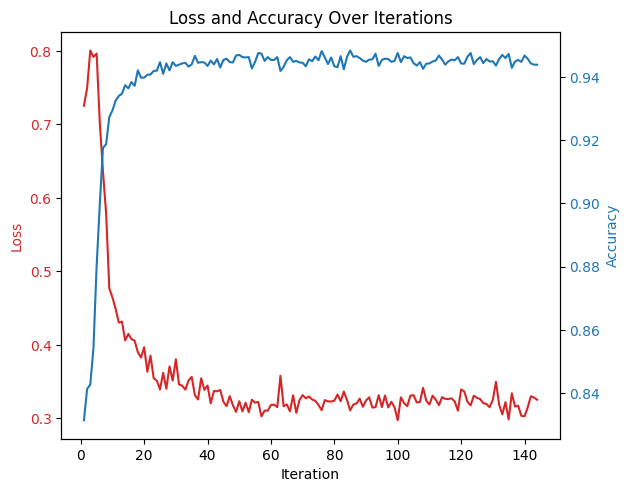

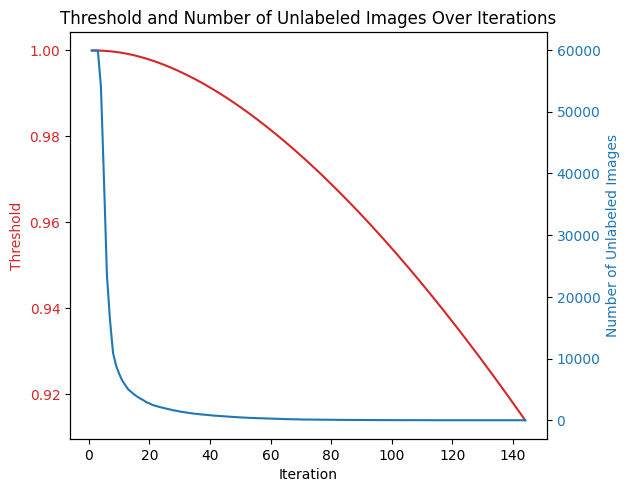

In [117]:
import matplotlib.pyplot as plt

# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color=color)
ax1.plot(iterations, losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(iterations, accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Loss and Accuracy Over Iterations')
plt.show()

# Plot threshold and number of unlabeled images
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Threshold', color=color)
ax1.plot(iterations, thresholds, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Number of Unlabeled Images', color=color)
ax2.plot(iterations, unlabeled_images, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Threshold and Number of Unlabeled Images Over Iterations')
plt.show()
